### 几个发现

- bitmex似乎只能查到最近几天的交易和委托历史。在10月27日下午18点登录网页查看，只能查到10月22日以来的交易记录和委托记录
- textnet测试发现，已撤单的订单在大约10分钟之后会消失，网页端和REST-API(/execution)都查不到了。
- 实盘成交价格可能会超出REST-API查询的历史k线范围。已用实盘交易记录验证（自营账户10月24日4笔买单）

In [1]:
import datetime

report_days = 2   # 最近5天的报告

report_from = datetime.datetime.now() - datetime.timedelta(days=report_days) 
startTime = datetime.datetime.strftime(report_from, '%Y-%m-%d') # '2018-10-20'
endTime = None
symbol = 'XBTUSD'
bar_type = '5m'

account_settings_file = '../bitmex/BITMEX_connect.json'
which = 'real_trading_TINGHAO'  #'account_test'

In [2]:
import sys
sys.path.append("../")

from bitmex.bitmexREST import bitmexREST
from bitmex.bitmexAccountSettings import bitmexAccountSettings

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",101)

In [3]:
acc = bitmexAccountSettings()
acc.from_config_file(account_settings_file, which)

In [4]:
rest = bitmexREST(apiKey=acc.apiKey, apiSecret=acc.apiSecret, isTestNet=acc.isTestNet)

## 复盘，检查交易，交易质量分析

In [5]:
# execution

execution_result = rest.query_history_execution(symbol, startTime, endTime)
df_exec = pd.DataFrame(execution_result)
df_exec['DATETIME'] = pd.to_datetime(df_exec['transactTime'])
#df_exec.head()

In [6]:
# order

order_result = rest.query_history_order(symbol, startTime, endTime)
df_order = pd.DataFrame(order_result)
df_order['DATETIME'] = pd.to_datetime(df_order['transactTime'])
#df_order   # side, price, DATETIME

In [7]:
# position

# REST api 没有历史仓位变化查询。只能查到当前时间截面上的持仓。
# Websocket api 可以收实时持仓变化。

In [8]:
symbol, startTime, endTime, bar_type

('XBTUSD', '2018-11-19', None, '5m')

In [9]:
rest_no_auth = bitmexREST(None, None, True)
market_result = rest_no_auth.query_history_bars(symbol, startTime, endTime, bar_type)

In [10]:
df_market = pd.DataFrame(market_result)
df_market['DATETIME'] = pd.to_datetime(df_market['timestamp'])
df_market['DATE'] = [x.date() for x in df_market.DATETIME]

In [11]:
df_market.head()

,close,foreignNotional,high,homeNotional,lastSize,low,open,symbol,timestamp,trades,turnover,volume,vwap,DATETIME,DATE
0,5515.0,100723,5528.0,18.258925,6,5514.5,5519.5,XBTUSD,2018-11-19T00:00:00.000Z,144,1825892543,100723,5516.6326,2018-11-19 00:00:00,2018-11-19
1,5493.5,331832,5517.5,60.379422,86,5480.0,5515.0,XBTUSD,2018-11-19T00:05:00.000Z,701,6037942228,331832,5496.0154,2018-11-19 00:05:00,2018-11-19
2,5490.0,57530,5496.0,10.476200,500,5481.0,5493.5,XBTUSD,2018-11-19T00:10:00.000Z,118,1047620024,57530,5491.7898,2018-11-19 00:10:00,2018-11-19
3,5512.0,207117,5515.5,37.615290,522,5491.0,5490.0,XBTUSD,2018-11-19T00:15:00.000Z,159,3761528973,207117,5506.3047,2018-11-19 00:15:00,2018-11-19
4,5515.5,66756,5515.5,12.108671,195,5510.0,5512.0,XBTUSD,2018-11-19T00:20:00.000Z,123,1210867085,66756,5513.2870,2018-11-19 00:20:00,2018-11-19


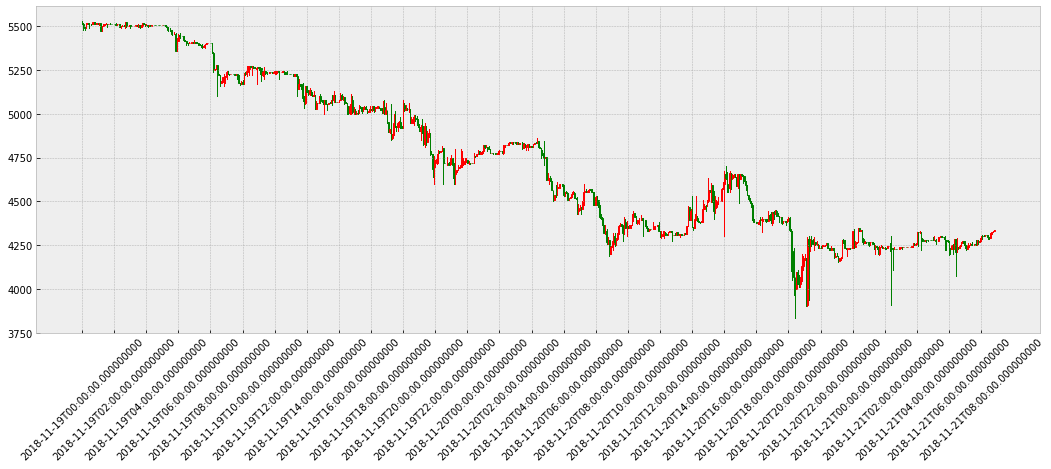

In [12]:
from qsPlot import ohlc_plot
plt.style.use('bmh')


fig, ax = plt.subplots(figsize=(18,6))
ohlc_plot(ax, df_market, t_='DATETIME', width_=0.5, n_=24)
_=plt.xticks(rotation=45)

In [13]:
df_Exec_Trade_Buy = df_exec.query('execType == "Trade" & side=="Buy"')
df_Exec_Trade_Sell = df_exec.query('execType == "Trade" & side=="Sell"')

df_Exec_New = df_exec.query('execType == "New"')
df_Exec_Canceled = df_exec.query('execType == "Canceled"')

print('Buy: %d'% len(df_Exec_Trade_Buy))
print('Sell: %d'% len(df_Exec_Trade_Sell))
print('New: %d' % len(df_Exec_New))
print('Canceled: %d' % len(df_Exec_Canceled))

Buy: 16
Sell: 17
New: 0
Canceled: 0


In [14]:
df_Order_Buy = df_order.query('side == "Buy"')
df_Order_Sell = df_order.query('side == "Sell"')

print('Order_Buy: %s' % len(df_Order_Buy))
print('Order_Sell: %s' % len(df_Order_Sell))
print('Order time range: %s' % (df_order.DATETIME.values[[0, -1]]))

Order_Buy: 13
Order_Sell: 11
Order time range: ['2018-11-19T01:09:45.793000000' '2018-11-20T15:28:24.574000000']


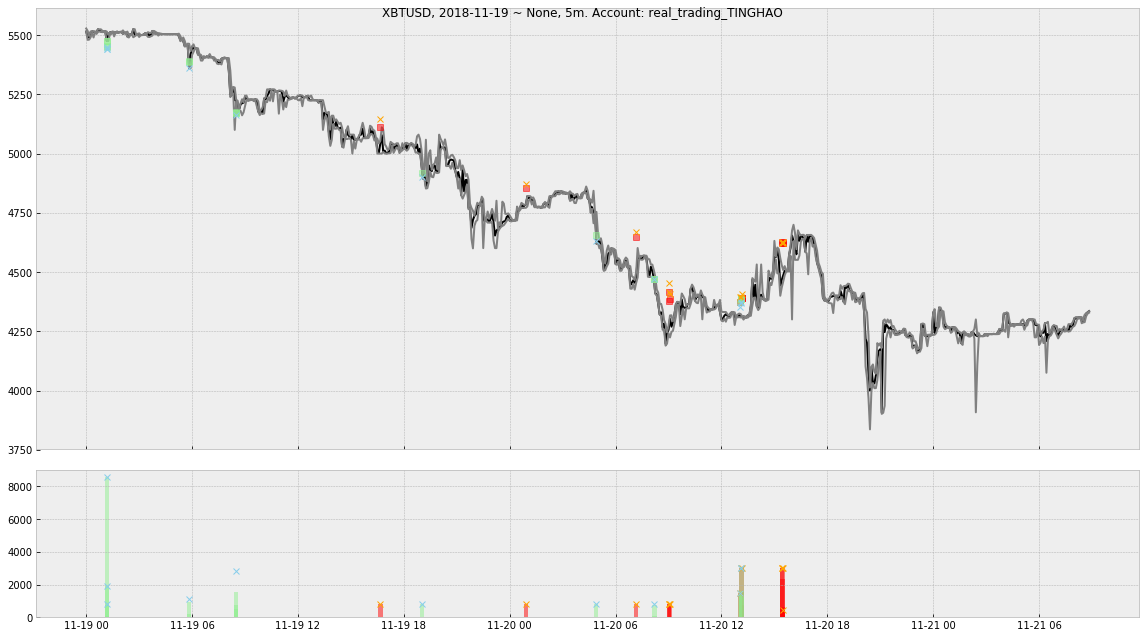

In [15]:
fig,axs = plt.subplots(2, 1, sharex=True, figsize=(16, 9), gridspec_kw = {'height_ratios':[3, 1]})
fig.tight_layout()
fig.suptitle('%s, %s ~ %s, %s. Account: %s' % (symbol, startTime, endTime, bar_type, which))

ax = axs[0]

# marketprice
ax.plot(df_market.DATETIME, df_market.close, color='k')
ax.plot(df_market.DATETIME, df_market.high, color='grey')
ax.plot(df_market.DATETIME, df_market.low, color='grey')

# execution
ax.plot(df_Exec_Trade_Buy.DATETIME, df_Exec_Trade_Buy['lastPx'], 's', color='red', alpha=0.5)
ax.plot(df_Exec_Trade_Sell.DATETIME, df_Exec_Trade_Sell['lastPx'], 's', color='lightgreen', alpha=0.5)
#ax.plot(df_Exec_New.DATETIME, df_Exec_New['price'], 'o', color='blue')
#ax.plot(df_Exec_Canceled.DATETIME, df_Exec_Canceled['price'], '*', color='blue')

# order
#ax.plot(df_Order_Buy.DATETIME, df_Order_Buy['avgPx'], 'o', color='orange')
#ax.plot(df_Order_Sell.DATETIME, df_Order_Sell['avgPx'], 'o', color='skyblue')
ax.plot(df_Order_Buy.DATETIME, df_Order_Buy['price'], 'x', color='orange')
ax.plot(df_Order_Sell.DATETIME, df_Order_Sell['price'], 'x', color='skyblue')

from matplotlib.dates import DateFormatter

ax.xaxis.set_major_formatter(DateFormatter('%b%d %H:%M:%S'))
#_=plt.xticks(rotation=45)
#_=ax.set_title('%s, %s, %s ~ %s, %s' % (acc.account, symbol, startTime, endTime, bar_type))

ax2 = axs[1]
ax2.bar(df_Exec_Trade_Buy.DATETIME, df_Exec_Trade_Buy['lastQty'], width=0.01, color='red', alpha=0.5)
ax2.bar(df_Exec_Trade_Sell.DATETIME, df_Exec_Trade_Sell['lastQty'], width=0.01, color='lightgreen', alpha=0.5)

ax2.plot(df_Order_Buy.DATETIME, df_Order_Buy['orderQty'], 'x', color='orange')
ax2.plot(df_Order_Sell.DATETIME, df_Order_Sell['orderQty'], 'x', color='skyblue')

关于 REST \order 的几个结论

1. 历史数据只有**已完成订单**的记录。
    - ordStatus只有Filled， 之前已经发现，New和Canceled过几分钟之后就会消失。
    - all(workingIndicator == False)
    - all(leavesQty == 0)
    - all(cumQty == orderQty)
2. 一行一个OrderID

In [16]:
df_order.ordStatus.unique()   # [Filled]
df_order.workingIndicator.unique()  # [False]
df_order.leavesQty.unique()   # [0]
all(df_order.cumQty == df_order.orderQty)  # True

len(df_order.orderID.unique()) == len(df_order)   # True

df_order.ordType.unique()  # [Limit]
df_order.side.unique()  # [Buy, Sell]

df_order.columns

Index(['account', 'avgPx', 'clOrdID', 'clOrdLinkID', 'contingencyType',
       'cumQty', 'currency', 'displayQty', 'exDestination', 'execInst',
       'leavesQty', 'multiLegReportingType', 'ordRejReason', 'ordStatus',
       'ordType', 'orderID', 'orderQty', 'pegOffsetValue', 'pegPriceType',
       'price', 'settlCurrency', 'side', 'simpleCumQty', 'simpleLeavesQty',
       'simpleOrderQty', 'stopPx', 'symbol', 'text', 'timeInForce',
       'timestamp', 'transactTime', 'triggered', 'workingIndicator',
       'DATETIME'],
      dtype='object')

## 钱包余额

一个问题： REST /user/walletHistory 只能取到近期232条数据（今天是2018/11/21，取到的数据从2018/02/17开始）

In [17]:
wallet_result = rest.query_history_wallet(currency='XBt')

df_wallet = pd.DataFrame(wallet_result)

In [18]:
len(df_wallet)   # TODO: 只能取到232条记录，

232

In [19]:
df_wallet.timestamp.iloc[0], df_wallet.timestamp.iloc[-1]

('2018-11-21T12:00:00.000Z', '2018-02-17T07:25:21.872Z')

In [20]:
df_wallet['DATETIME'] = pd.to_datetime(df_wallet['timestamp'])
df_wallet['DATE'] = [x.date() for x in df_wallet['DATETIME']]
#df_wallet = df_wallet.set_index('DATE')

In [21]:
#df_wallet

In [22]:
# 画图时间窗口
wallet_start = '2018-06-01'
df_wallet_plot = df_wallet.loc[df_wallet.DATE.astype(str) > wallet_start]
df_wallet_plot = df_wallet_plot.loc[1:]

# XBT单位
xbt_unit_dict = {
    'mXBT': 1e5,
    'XBT': 1e8
}

xbt_unit = 'XBT'

df_wallet_plot['amount'] = df_wallet_plot['amount'] / xbt_unit_dict[xbt_unit]
df_wallet_plot['walletBalance'] = df_wallet_plot['walletBalance'] / xbt_unit_dict[xbt_unit]

# 资金进出
df_wallet_deposit = df_wallet_plot[df_wallet_plot.transactType == 'Deposit']
df_wallet_withdrawal = df_wallet_plot[df_wallet_plot.transactType == 'Withdrawal']

# 累计交易盈亏（不算资金进出）
df_transaction_pnl = df_wallet_plot[df_wallet_plot.transactType == 'RealisedPNL']
df_transaction_pnl = df_transaction_pnl.reindex()
df_transaction_pnl['cum_pnl'] = (-df_transaction_pnl['amount']).cumsum()  # ？？？ -amount

In [ ]:
plt.style.use('bmh')
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 12))
fig.suptitle('%s  (Y-axis unit:%s)' % (which, xbt_unit))

axs[0].plot(df_wallet_plot['DATE'], df_wallet_plot['walletBalance'])
axs[0].set_title('Wallet Balance (including deposit && widthdraw)')

axs[1].set_title('Wallet Balance daily change (including deposit && widthdraw)')
axs[1].bar(df_wallet_plot['DATE'], df_wallet_plot['amount'])
axs[1].bar(df_wallet_deposit['DATE'], df_wallet_deposit['amount'], label='deposit')
#axs[1].bar(df_wallet_withdrawal['DATE'], df_wallet_withdrawal['amount'], label='widthdrawal')
axs[1].legend()

axs[2].set_title('cummulative transaction pnl')
axs[2].plot(df_transaction_pnl['DATE'], df_transaction_pnl['cum_pnl'], color='C4')

axs[3].set_title('daily transaction pnl')
axs[3].bar(df_transaction_pnl['DATE'], df_transaction_pnl['amount'], color='C5')

<Container object of 150 artists>